# Hidden markov models 
Para complementar el meta labeling, se aplican cadenas de markov para obtener las distintas regiones de volatilidad. 

In [1]:
import sys
import os
import pandas as pd

# Añadir el directorio raíz del proyecto al PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import quantstats as qs

from hmmlearn.hmm import GaussianHMM


In [2]:
# DATOS ORIGINALES

#SPY
spy_data = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\00_api_data\SPY_all.parquet')
spy_dollar_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\01_imbalance_bars\SPY_dollar_imbalance.parquet')
spy_volume_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\01_imbalance_bars\SPY_volume_imbalance.parquet')


#BTC
btc_data = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\00_api_data\BTC_all.parquet')
btc_dollar_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\01_imbalance_bars\BTC_dollar_imbalance.parquet')
btc_volume_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\01_imbalance_bars\BTC_volume_imbalance.parquet')


btc_data['date'] = pd.to_datetime(btc_data['date'])
spy_data['date'] = pd.to_datetime(spy_data['date'])

In [3]:
# CALCULO RANGO
spy_data["range"] = (spy_data["high"] / spy_data["low"])-1
spy_dollar_imb["range"] = (spy_dollar_imb["high"] / spy_dollar_imb["low"])-1
spy_volume_imb["range"] = (spy_volume_imb["high"] / spy_volume_imb["low"])-1
btc_data["range"] = (btc_data["high"] / btc_data["low"])-1
btc_dollar_imb["range"] = (btc_dollar_imb["high"] / btc_dollar_imb["low"])-1
btc_volume_imb["range"] = (btc_volume_imb["high"] / btc_volume_imb["low"])-1

# SPY

In [4]:
percent_80 = int(len(spy_data)*0.8)
X_train = spy_data[["log_returns", "range"]]#.iloc[:percent_80]
X_test = spy_data[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(spy_data) }")

X_train From:	 1  to  662353 | Length:  662353
X_test From:	 529883  to  662353 | Length:  132471
Total samples: 794824. Están todos?: False


In [5]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 8596278.964834195


In [8]:
spy_data['HMM'] = hmm_model.predict(spy_data[["log_returns", "range"]])

In [9]:
spy_data['HMM'].value_counts()

HMM
1    344031
2    195299
0    114142
3      8881
Name: count, dtype: int64

In [12]:
spy_original_hmm = spy_data[['date','HMM']].copy()
spy_original_hmm.to_parquet('spy_original_hmm.parquet')

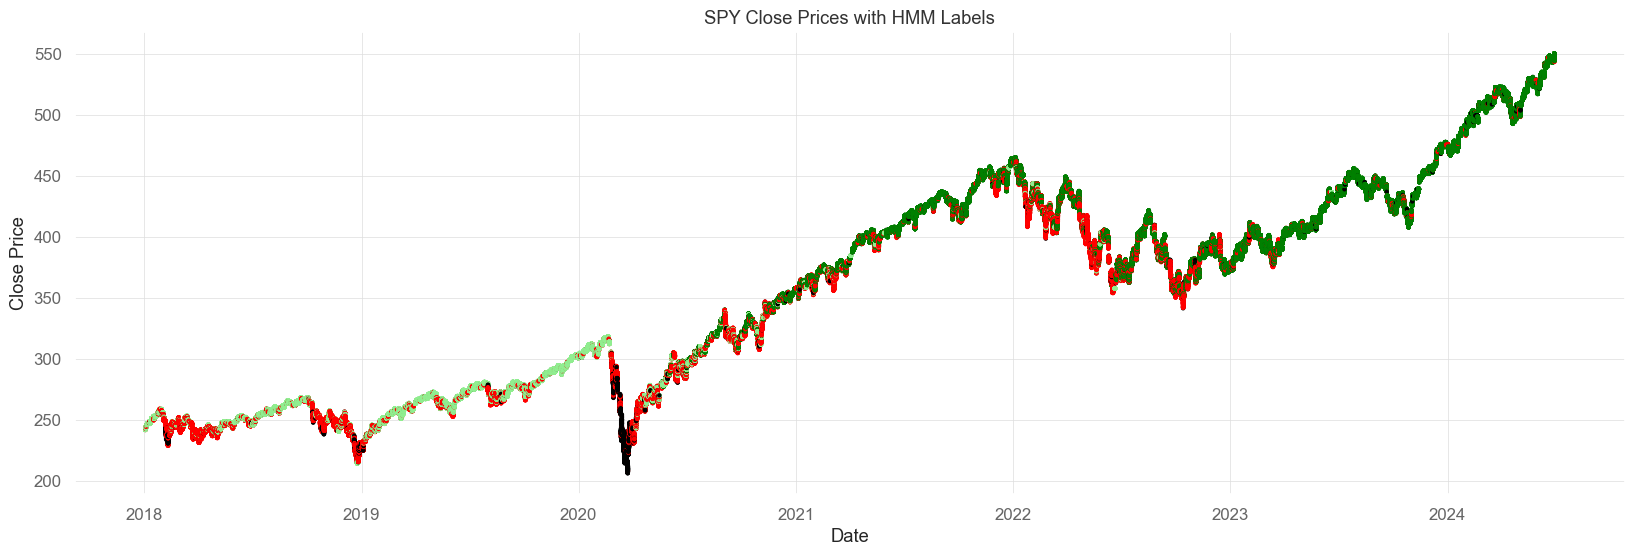

In [11]:
# Convertir 'date' a datetime si es necesario
spy_data['date'] = pd.to_datetime(spy_data['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'green', 
    2: 'lightgreen', 
    3: 'black'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = spy_data['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(spy_data['date'], spy_data['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# SPY VOLUME

In [15]:
percent_80 = int(len(spy_volume_imb)*0.8)
X_train = spy_volume_imb[["log_returns", "range"]]#.iloc[:percent_80]
X_test = spy_volume_imb[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(spy_volume_imb) }")

X_train From:	 1  to  55430 | Length:  55430
X_test From:	 44345  to  55430 | Length:  11086
Total samples: 66516. Están todos?: False


In [16]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 577171.183292468


In [17]:
spy_volume_imb['HMM'] = hmm_model.predict(spy_volume_imb[["log_returns", "range"]])

In [18]:
spy_volume_imb['HMM'].value_counts()

HMM
0    27172
3    25781
2     1588
1      889
Name: count, dtype: int64

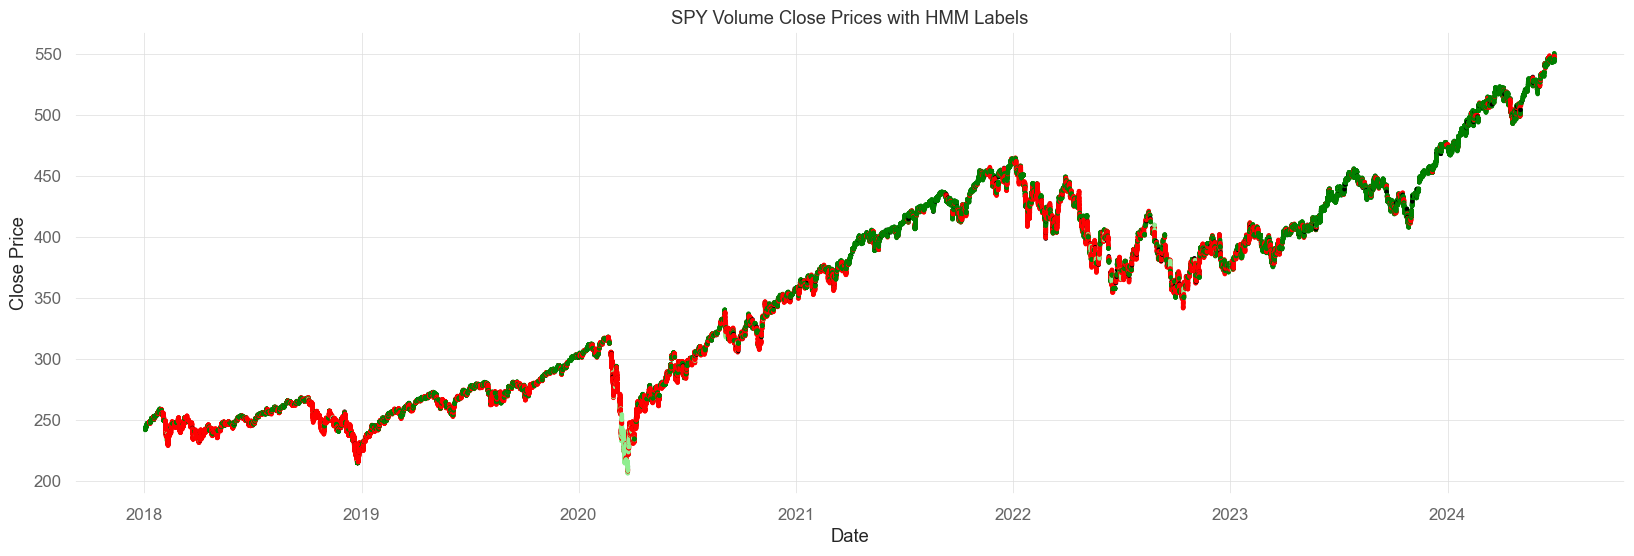

In [19]:
# Convertir 'date' a datetime si es necesario
spy_volume_imb['date'] = pd.to_datetime(spy_volume_imb['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = spy_volume_imb['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(spy_volume_imb['date'], spy_volume_imb['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Volume Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [26]:
spy_volume_hmm = spy_volume_imb[['date','HMM']].copy()
spy_volume_hmm.to_parquet('spy_volume_hmm.parquet')

# SPY DOLLAR

In [20]:
percent_80 = int(len(spy_dollar_imb)*0.8)
X_train = spy_dollar_imb[["log_returns", "range"]]#.iloc[:percent_80]
X_test = spy_dollar_imb[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(spy_dollar_imb) }")

X_train From:	 1  to  85228 | Length:  85228
X_test From:	 68183  to  85228 | Length:  17046
Total samples: 102274. Están todos?: False


In [21]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model is not converging.  Current: 931875.2700100692 is not greater than 931875.2741244083. Delta is -0.004114339011721313


Model Score: 931875.2106608751


In [22]:
spy_dollar_imb['HMM'] = hmm_model.predict(spy_dollar_imb[["log_returns", "range"]])

In [23]:
spy_dollar_imb['HMM'].value_counts()

HMM
2    45917
3    21086
1    16165
0     2060
Name: count, dtype: int64

In [25]:
spy_dollar_hmm = spy_dollar_imb[['date','HMM']].copy()
spy_dollar_hmm.to_parquet('spy_dollar_hmm.parquet')

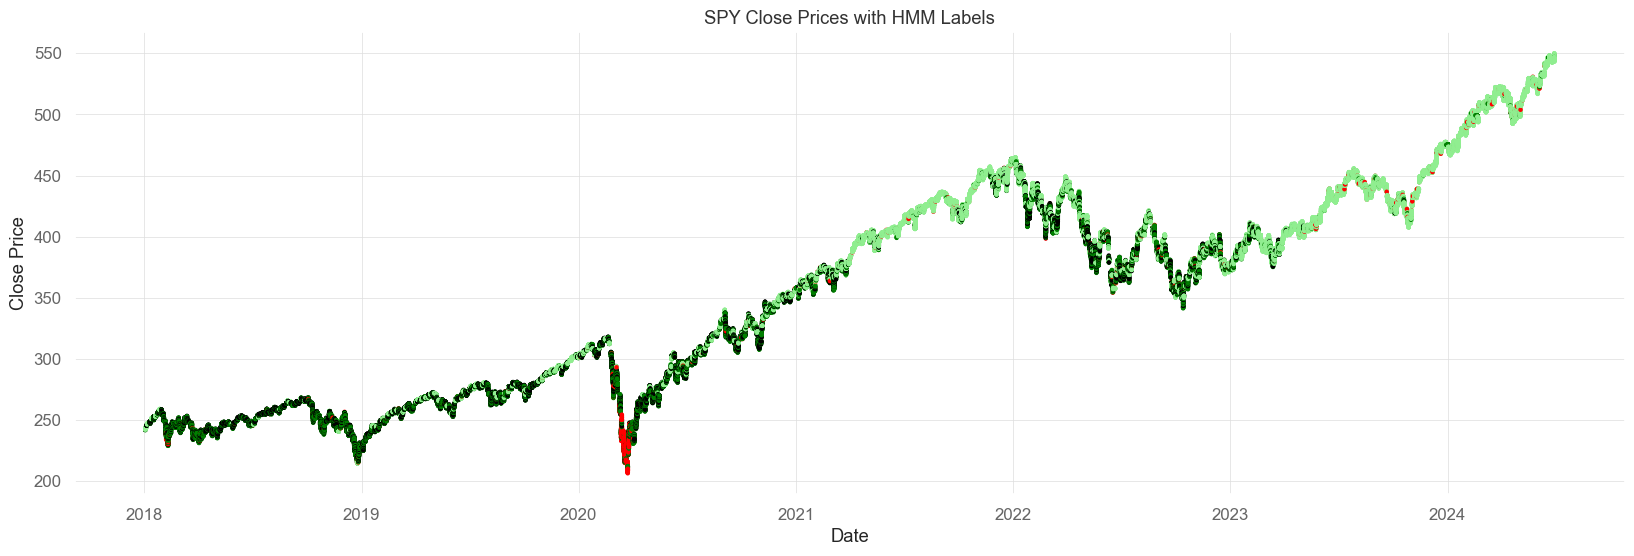

In [24]:
# Convertir 'date' a datetime si es necesario
spy_dollar_imb['date'] = pd.to_datetime(spy_dollar_imb['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = spy_dollar_imb['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(spy_dollar_imb['date'], spy_dollar_imb['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# BTC

In [27]:
percent_80 = int(len(spy_data)*0.8)
X_train = btc_data[["log_returns", "range"]]#.iloc[:percent_80]
X_test = btc_data[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(btc_data) }")

X_train From:	 1  to  3417119 | Length:  3417119
X_test From:	 529883  to  3417119 | Length:  2887237
Total samples: 6304356. Están todos?: False


In [28]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model is not converging.  Current: 35898196.17776907 is not greater than 35898210.525936045. Delta is -14.348166972398758


Model Score: 35898148.8322296


In [29]:
btc_data['HMM'] = hmm_model.predict(btc_data[["log_returns", "range"]])

In [30]:
btc_data['HMM'].value_counts()

HMM
1    1250478
0    1063065
3     602469
2     501107
Name: count, dtype: int64

In [31]:
btc_original_hmm = btc_data[['date','HMM']].copy()
btc_original_hmm.to_parquet('btc_original_hmm.parquet')

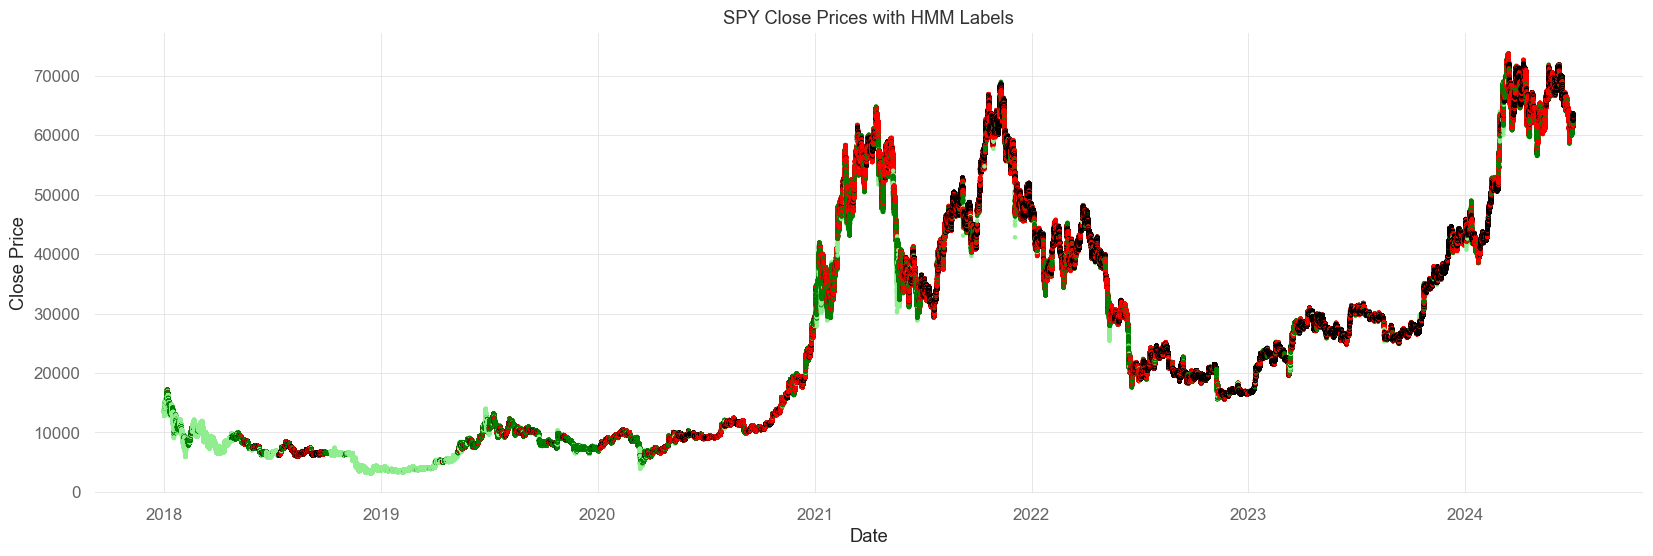

In [32]:
# Convertir 'date' a datetime si es necesario
btc_data['date'] = pd.to_datetime(btc_data['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = btc_data['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(btc_data['date'], btc_data['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# BTC VOLUME

In [33]:
percent_80 = int(len(btc_volume_imb)*0.8)
X_train = btc_volume_imb[["log_returns", "range"]]#.iloc[:percent_80]
X_test = btc_volume_imb[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(btc_volume_imb) }")

X_train From:	 1  to  110772 | Length:  110772
X_test From:	 88618  to  110772 | Length:  22155
Total samples: 132927. Están todos?: False


In [34]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 896936.6979243947


In [35]:
btc_volume_imb['HMM'] = hmm_model.predict(btc_volume_imb[["log_returns", "range"]])

In [36]:
btc_volume_imb['HMM'].value_counts()

HMM
2    41121
3    30117
0    26351
1    13183
Name: count, dtype: int64

In [37]:
btc_volume_hmm = btc_volume_imb[['date','HMM']].copy()
btc_volume_hmm.to_parquet('btc_volume_hmm.parquet')

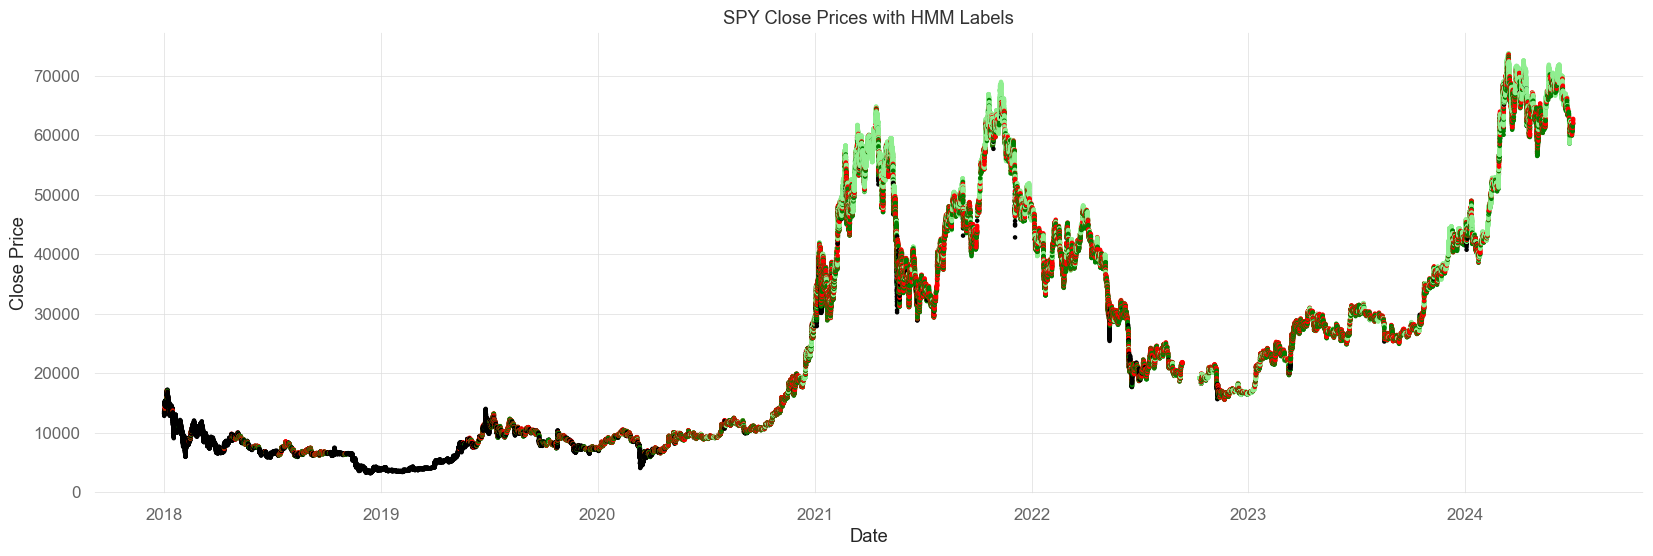

In [38]:
# Convertir 'date' a datetime si es necesario
btc_volume_imb['date'] = pd.to_datetime(btc_volume_imb['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = btc_volume_imb['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(btc_volume_imb['date'], btc_volume_imb['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# BTC DOLLAR

In [39]:
percent_80 = int(len(btc_dollar_imb)*0.8)
X_train = btc_dollar_imb[["log_returns", "range"]].iloc[:percent_80]
X_test = btc_dollar_imb[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(btc_dollar_imb) }")

X_train From:	 1  to  803004 | Length:  803004
X_test From:	 803005  to  1003756 | Length:  200752
Total samples: 1003756. Están todos?: True


In [40]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 8388590.262621976


In [41]:
btc_dollar_imb['HMM'] = hmm_model.predict(btc_dollar_imb[["log_returns", "range"]])

In [42]:
btc_dollar_imb['HMM'].value_counts()

HMM
0    475637
2    357440
1    128828
3     41851
Name: count, dtype: int64

In [43]:
btc_dollar_hmm = btc_dollar_imb[['date','HMM']].copy()
btc_dollar_hmm.to_parquet('btc_dollar_hmm.parquet')

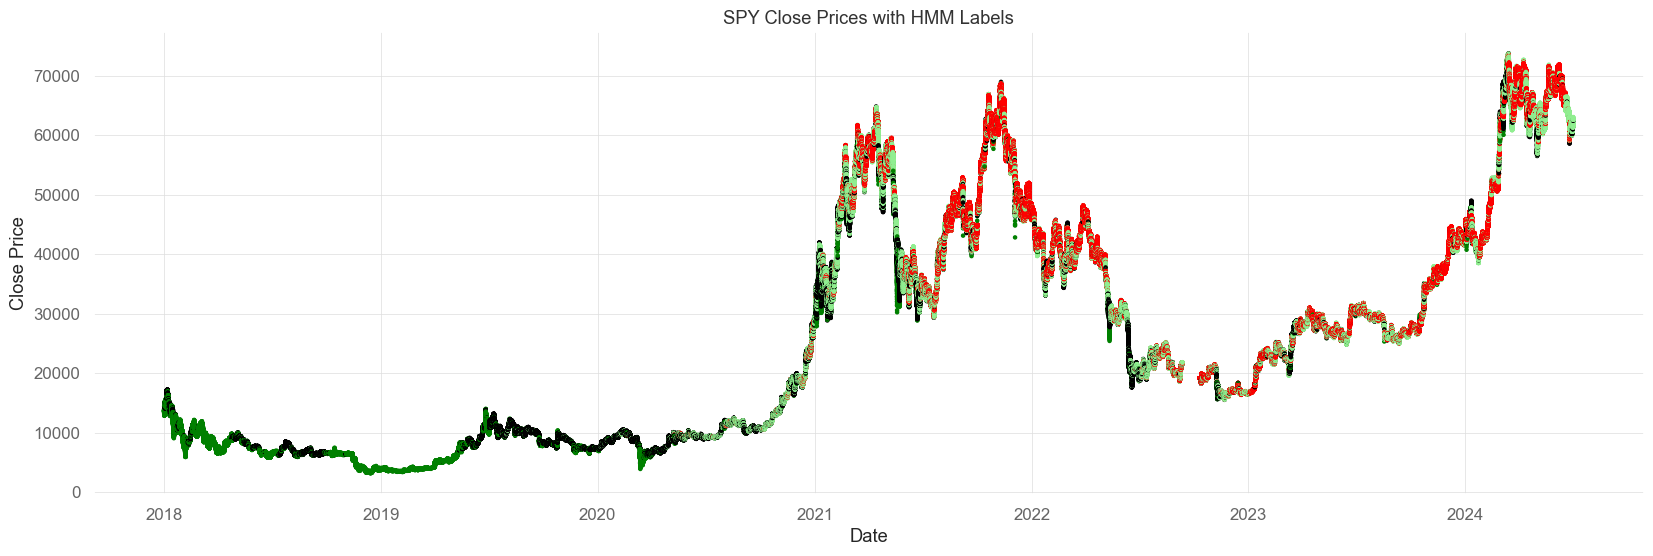

In [44]:
# Convertir 'date' a datetime si es necesario
btc_dollar_imb['date'] = pd.to_datetime(btc_dollar_imb['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = btc_dollar_imb['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(btc_dollar_imb['date'], btc_dollar_imb['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()